# Run single subject seed correlations for an initial QA

### The code is devided into two steps:
#### 1. Regress out confounds  (regressing out the confounds can be done by load_confounds instead of the method used here)
#### 2. Calculate seed correlations and plot.

An outer for loop over all subjects can be implemented by wrapping the code.

### Imports


In [36]:
from nilearn import image as nimg
from nilearn import plotting as nplot
from nilearn import masking
import pandas as pd
import numpy as np
from nilearn import input_data
import os

## Step 1
### Setting up and cleaning

#### Prepare a list of all subjects (if you want to loop over all subs). 
The names should match the subject directory name.


In [37]:
subs = ['Y01', 'Y02', 'Y03', 'Y04', 'Y05', 'Y06', 'Y07', 'Y08', 'Y10', 'Y11', 'Y12',
        'Y13', 'Y14','Y16', 'Y17', 'Y19', 'Y20']
descs = ['preproc', 'smoothAROMAnonaggr_bold']
runs = [1 ,2]

In [38]:
os.chdir('/Users/haya_/Desktop/fmriprep')
os.getcwd()


'C:\\Users\\haya_\\Desktop\\fmriprep'

#### Set other parameters for file selection.
The parametrs can be looped over by a for loop, but since it is not possible to do so in a notebook, I'll just use one subject.

In [39]:
run = 2
desc = 'smoothAROMAnonaggr_bold'
sub = 'Y01'

#### Load file names:


In [40]:
func_file = f'sub-{sub}/ses-1/func/sub-{sub}_ses-1_task-rest_run-{run}_' \
                f'space-MNI152NLin6Asym_desc-{desc}.nii.gz'


confound_file = f'sub-{sub}/ses-1/func/sub-{sub}_ses-1_task-rest_run-{run}_' \
                    f'desc-confounds_timeseries.tsv'

confound_df = pd.read_csv(confound_file, delimiter='\t')

#### Load functinal image from file name:

In [41]:
func_img = nimg.load_img(func_file)

### Creating a brain mask for the functinal image. 
We do this because later we are going to be applying the mask to the img (when callling the clean_img function). Shape/dimensions of the img and the mask must match. This step is not needed if we are using a file that ends with "desc-preproc_bold.nii.gz", because fmriprep already supplies a matching mask for this file, but since we are not using the defult file I have to create a new matching mask.



In [42]:
brain_mask = masking.compute_brain_mask(func_img)

### Chossing confound regressors:

Original code from: https://github.com/carpentries-incubator/SDC-BIDS-fMRI/blob/128f3c3fbefd48c7e63ebd2660f45c0b93e31ec6/code/05_data-cleaning-with-nilearn_solutions.ipynb
                                                                  
The Yeo 2011 Pre-processing schema
Confound regressors:
    6 motion parameters (trans_x, trans_y, trans_z, rot_x, rot_y, rot_z.
    Global signal (global_signal).
    Cerebral spinal fluid signal (csf).
    White matter signal (white_matter).

This is a total of 9 base confound regressor variables. 
then we add temporal derivatives of each of these signals as well (1 temporal derivative for each), the result is 18 confound regressors.
Temporal Derivatives are the changes in values across 2 consecutive samples. It represents change in signal over time.
For example, when dealing with the confound variable "X", which represents motion along the "trans_x" direction, 
the temporal derivative represents velocity in the X direction.

In [43]:
# here we pick our base confound regressors as done in Yeo 2011's pre-processing framework
confound_vars = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'global_signal', 'csf',
                 'white_matter']

# Get derivative column names fMRIPrep provides this for us. Derivative columns are denoted as the following:
#     {NAME_OF_COLUMN}_derivative1

derivative_columns = ['{}_derivative1'.format(c) for c in confound_vars]

# print("derivative_columns:\n", derivative_columns)

final_confounds = confound_vars + derivative_columns

# print("final confounds\n", final_confounds)

confound_df = confound_df[final_confounds]

print("confound df head:")
confound_df.head()

confound df head:


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,global_signal,csf,white_matter,trans_x_derivative1,trans_y_derivative1,trans_z_derivative1,rot_x_derivative1,rot_y_derivative1,rot_z_derivative1,global_signal_derivative1,csf_derivative1,white_matter_derivative1
0,-4.472990e-09,0.000000,3.333600e-09,0.000000,-7.801070e-05,0.000000,571.392746,487.973242,542.334672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.928960e-05,0.088603,6.097940e-02,-0.000284,-9.464280e-05,0.000157,570.148566,483.478172,541.410483,0.000019,0.088603,0.060979,-0.000284,-0.000017,0.000157,-1.244180,-4.495070,-0.924189
2,-3.643880e-07,-0.045601,2.310660e-02,0.000039,-1.371490e-24,0.000202,568.657792,480.102519,540.997292,-0.000020,-0.134204,-0.037873,0.000323,0.000095,0.000046,-1.490775,-3.375653,-0.413191
3,1.410900e-05,0.020789,4.190990e-02,0.000010,-1.532280e-04,0.000136,568.009606,476.473548,540.204898,0.000014,0.066390,0.018803,-0.000029,-0.000153,-0.000066,-0.648186,-3.628971,-0.792394
4,-7.656770e-03,0.087604,3.237300e-02,-0.000347,-0.000000e+00,0.000179,567.386158,477.674833,540.590564,-0.007671,0.066815,-0.009537,-0.000357,0.000153,0.000043,-0.623448,1.201285,0.385666


#### Removing the first 4 timepoints from our functional image:

In [44]:
print("func_img shape", func_img.shape)

func_img = func_img.slicer[:, :, :, 4:]

print("func_img shape", func_img.shape)



func_img shape (91, 109, 91, 379)
func_img shape (91, 109, 91, 375)


#### Removing the first 4 timepoints from the confounds df

In [45]:
print("confound df's shape: ", confound_df.shape)

confound_df = confound_df.loc[4:]

print("confound df's shape after droping first 4 trs: ", confound_df.shape)  # number of rows should match that of the functional image
print("confound df head after droping first 4 trs:")
confound_df.head()


confound df's shape:  (379, 18)
confound df's shape after droping first 4 trs:  (375, 18)
confound df head after droping first 4 trs:


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,global_signal,csf,white_matter,trans_x_derivative1,trans_y_derivative1,trans_z_derivative1,rot_x_derivative1,rot_y_derivative1,rot_z_derivative1,global_signal_derivative1,csf_derivative1,white_matter_derivative1
4,-0.007657,0.087604,0.032373,-0.000347,-0.000000,0.000179,567.386158,477.674833,540.590564,-0.007671,0.066815,-0.009537,-0.000357,0.000153,0.000043,-0.623448,1.201285,0.385666
5,-0.011295,-0.058754,0.032372,0.000351,-0.000279,0.000000,568.906355,477.926058,541.024376,-0.003639,-0.146357,-0.000001,0.000698,-0.000279,-0.000179,1.520197,0.251224,0.433813
6,-0.012230,0.100739,0.061115,-0.000006,-0.000273,0.000000,569.850669,477.660780,541.016082,-0.000935,0.159493,0.028743,-0.000357,0.000006,0.000000,0.944315,-0.265278,-0.008294
7,-0.009973,-0.001088,0.022369,0.000436,-0.000195,0.000000,569.966198,480.044273,542.119773,0.002257,-0.101827,-0.038746,0.000442,0.000078,0.000000,0.115529,2.383493,1.103691
8,-0.029340,0.018361,0.032478,0.000360,-0.000007,0.000000,569.812576,477.610009,541.991077,-0.019367,0.019449,0.010110,-0.000077,0.000188,0.000000,-0.153622,-2.434264,-0.128696


#### Convert data frame into a matrix


In [46]:
confounds_matrix = confound_df.values

# Confirm matrix size is correct, number of rows should be equal to 4'th dim in the functional image.
print("confounds matrix shape:\n", confounds_matrix.shape)

confounds matrix shape:
 (375, 18)


#### Set some constants according to The Yeo 2011 Pre-processing schema


In [47]:
high_pass = 0.009  # filtering minimum
low_pass = 0.08  # filtering maximum
t_r = 1.4

### Clean! 

In [48]:
# mask file source shuold be the actual func file
clean_img = nimg.clean_img(func_img, confounds=confounds_matrix, detrend=True, standardize=True,
                               low_pass=low_pass, high_pass=high_pass, t_r=t_r, mask_img=brain_mask)

C:\Users\haya_\anaconda3\lib\site-packages\nilearn\image\image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


## Step 2
### Calculate seed based correlations

Choose seed coordinates in MNI space

In [49]:
coords = [(-42, -16, 52)]

#### Extract the time series from the functional imaging within the sphere. 
The sphere is centered at coords and will have the radius we pass the NiftiSpheresMasker function (here 8 mm).

In [50]:
seed_masker = input_data.NiftiSpheresMasker(coords, radius=8, detrend=True, standardize=True, t_r=1.4,
                                                memory='nilearn_cache', memory_level=1, verbose=0)

# extract the mean time series 

seed_time_series = seed_masker.fit_transform(clean_img)

#### brain-wide voxel-wise time series, using nilearn.input_data.NiftiMasker with the same input arguments as in the seed_masker in addition to smoothing with a 6 mm kernel.

In [51]:
brain_masker = input_data.NiftiMasker(smoothing_fwhm=6, detrend=True, standardize=True,
                                          t_r=1.4, memory='nilearn_cache', memory_level=1, verbose=0)

# extract the brain-wide voxel-wise time series 

brain_time_series = brain_masker.fit_transform(clean_img)

C:\Users\haya_\anaconda3\lib\site-packages\nilearn\input_data\nifti_masker.py:518: UserWarning: Persisting input arguments took 9.46s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


 ### Check dimensions

In [52]:
print("Seed time series shape: ", seed_time_series.shape)  # sanity check
print("Brain time series shape: ", brain_time_series.shape)

Seed time series shape:  (375, 1)
Brain time series shape:  (375, 216619)


### Numpy calculations

In [53]:
# A reminder that np.dot is matrix multiplication if arguments are 2d arrays

seed_to_voxel_correlations = np.dot(brain_time_series.T, seed_time_series) / \
                                 seed_time_series.shape[0]
print("Seed-to-voxel correlation shape: (%s, %s)" % seed_to_voxel_correlations.shape)
print("Seed-to-voxel correlation: min = %.3f; max = %.3f" % (seed_to_voxel_correlations.min(),
                                                                 seed_to_voxel_correlations.max()))

Seed-to-voxel correlation shape: (216619, 1)
Seed-to-voxel correlation: min = -0.652; max = 0.995


#### Transform the 2D data matrix back to an image in brain space. 

In [54]:
seed_to_voxel_correlations_img = brain_masker.inverse_transform(seed_to_voxel_correlations.T)

#### Save img to a "nii.gz" file.

In [55]:
seed_to_voxel_correlations_img.to_filename(f'seed_to_voxel_corr_sub{sub}_run{run}_{desc}.nii.gz')

## Nilearn plotting options:

### Plotting option 1, a static brain map:

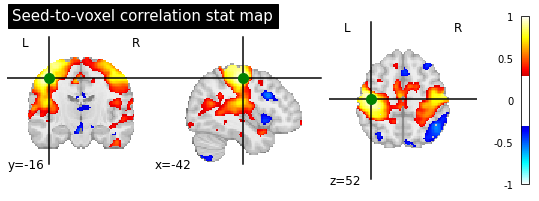

In [56]:
plot = nplot.plot_stat_map(seed_to_voxel_correlations_img, threshold=0.3, vmax=1, cut_coords=coords[0],
                                  title="Seed-to-voxel correlation stat map" , resampling_interpolation = 'continuous')

# Edit display parameters
plot.add_markers(marker_coords=coords, marker_color='g', marker_size=100)

# Save the plot as pdf.
plot.savefig('seed_correlation_run2.pdf')


### Plotting option 2, an interactive map:


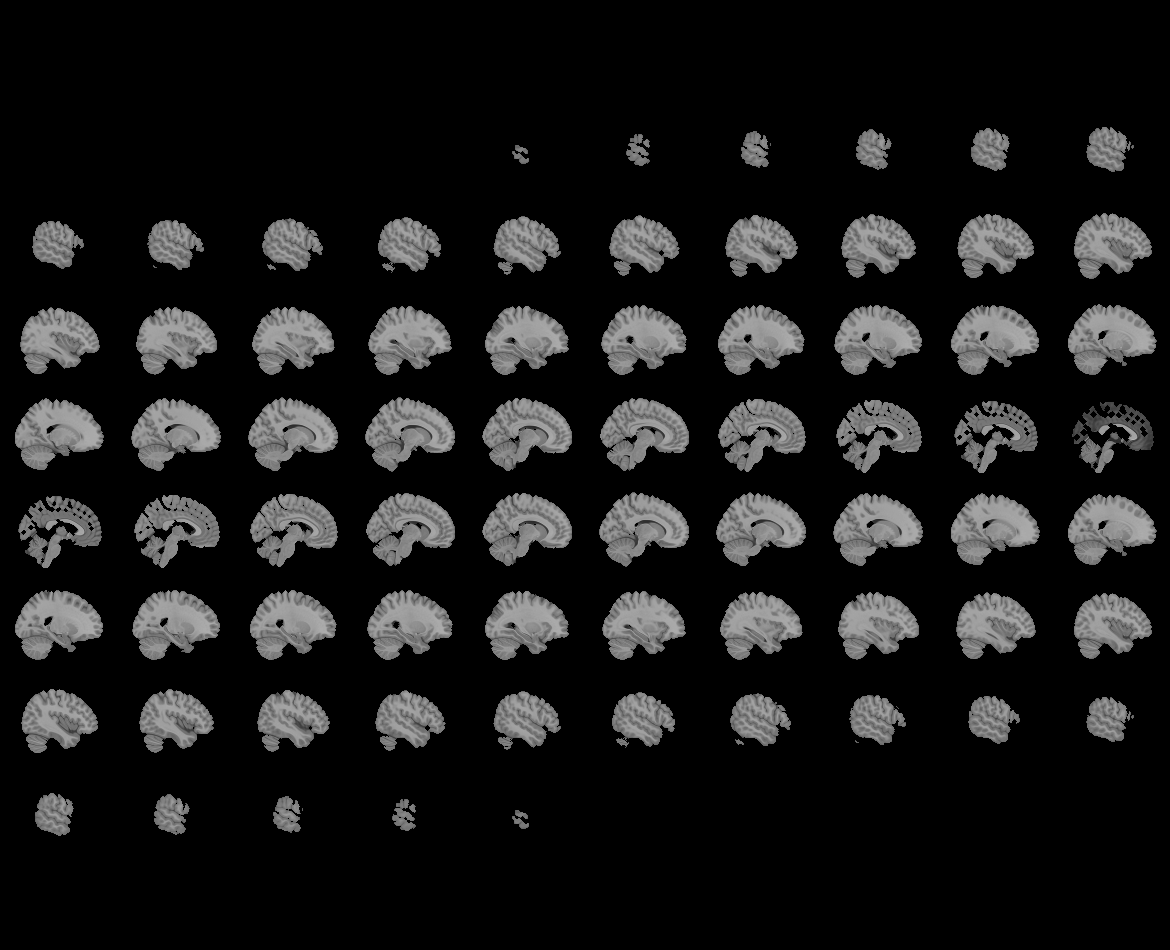
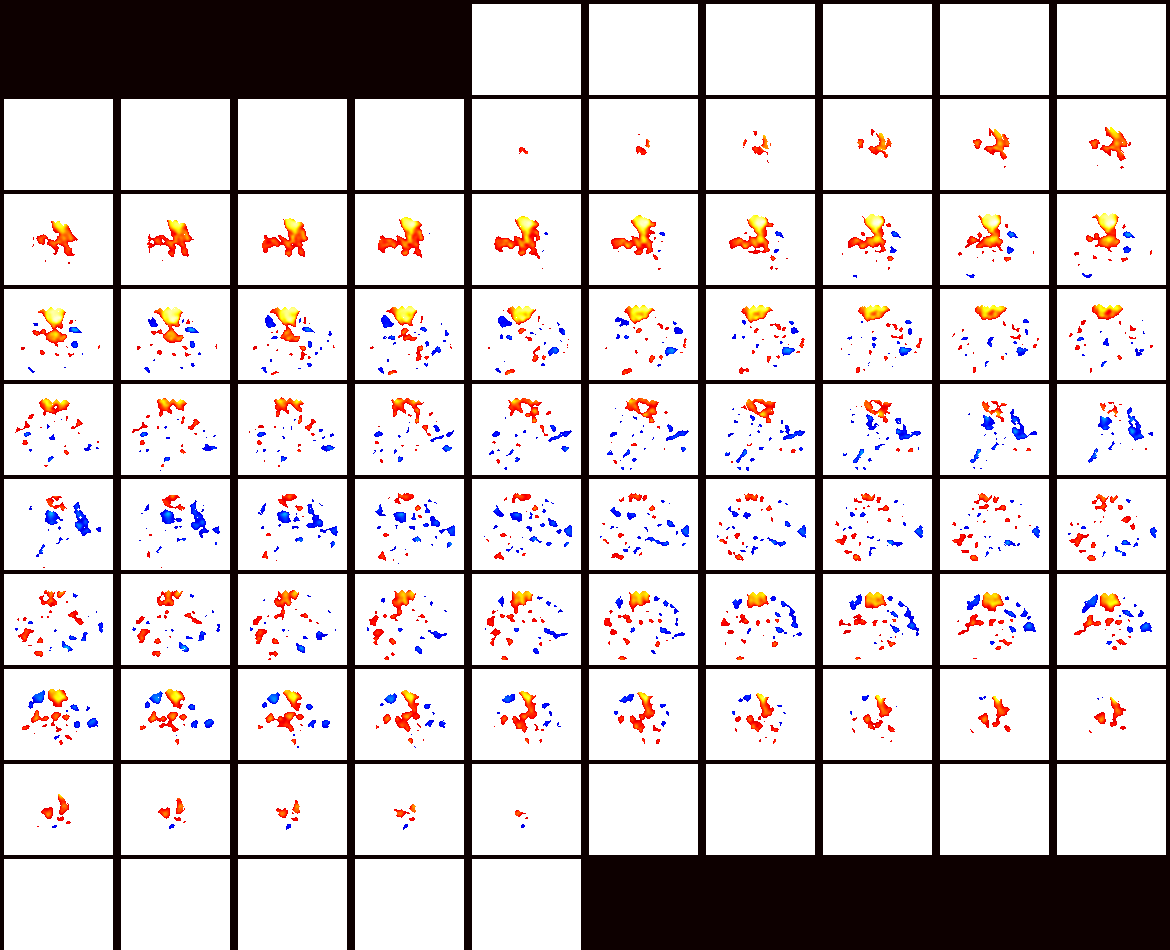

In [57]:
nplot.view_img(seed_to_voxel_correlations_img, threshold= 0.3, title="Interactive view", resampling_interpolation = 'continuous')

#Image can be oppened in a browser when working in an IDE with the following command:
#interactive_img = nplot.view_img(seed_to_voxel_correlations_img, threshold= 0.3, title="Interactive view", resampling_interpolation = 'continuous')
#interactive_img.open_in_browser() 

#We can also save as a html 
#interactive_img.save_as_html('interactive_seed_corr.html')

### Plotting option 3, a "glass brain" plot:

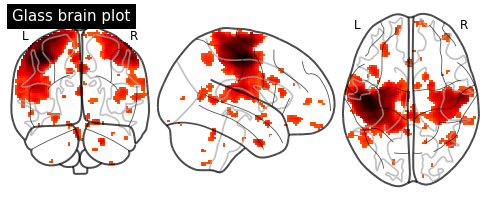

In [58]:
nplot.plot_glass_brain(seed_to_voxel_correlations_img, title='Glass brain plot',
                          threshold=0.5)
